# Calculating and plotting stresses and utilizations for Kirchhoff-Love plates


In [1]:
E = 2890.0
nu = 0.2
yield_strength = 2.0

Lx, Ly = 600.0, 800.0
thickness = 25.0

In [2]:
from sigmaepsilon.solid.material import KirchhoffPlateSection as Section
from sigmaepsilon.math.linalg import ReferenceFrame
from sigmaepsilon.solid.material import (
    ElasticityTensor,
    LinearElasticMaterial,
    HuberMisesHenckyFailureCriterion_SP,
)
from sigmaepsilon.solid.material.utils import elastic_stiffness_matrix

hooke = elastic_stiffness_matrix(E=E, NU=nu)
frame = ReferenceFrame(dim=3)
stiffness = ElasticityTensor(hooke, frame=frame, tensorial=False)

failure_model = HuberMisesHenckyFailureCriterion_SP(yield_strength=yield_strength)

material = LinearElasticMaterial(stiffness=stiffness, failure_model=failure_model)

section = Section(
    layers=[
        Section.Layer(material=material, thickness=thickness / 3),
        Section.Layer(material=material, thickness=thickness / 3),
        Section.Layer(material=material, thickness=thickness / 3),
    ]
)
ABDS = section.elastic_stiffness_matrix()
D = ABDS

f:\GitHub\SigmaEpsilon\sigmaepsilon.solid.material\.solid.material\lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [3]:
from sigmaepsilon.solid.fourier import (
    RectangularPlate,
    LoadGroup,
    PointLoad,
    RectangleLoad,
)

loads = LoadGroup(
    LG1=LoadGroup(
        LC1=RectangleLoad(x=[[0, 0], [Lx, Ly]], v=[-0.1, 0, 0]),
        LC2=RectangleLoad(x=[[Lx / 3, Ly / 2], [Lx / 2, 2 * Ly / 3]], v=[-1, 0, 0]),
    ),
    LG2=LoadGroup(
        LC3=PointLoad(x=[Lx / 3, Ly / 2], v=[-1000.0, 0, 0]),
        LC4=PointLoad(x=[2 * Lx / 3, Ly / 2], v=[100.0, 0, 0]),
    ),
)
loads.lock()


In [4]:
from sigmaepsilon.mesh.grid import grid
from sigmaepsilon.mesh import triangulate
from sigmaepsilon.mesh.utils.topology.tr import Q4_to_T3
from time import time

size = Lx, Ly = (600.0, 800.0)
shape = nx, ny = (30, 40)
gridparams = {"size": size, "shape": shape, "eshape": "Q4"}
coords, topo = grid(**gridparams)
coords, triangles = Q4_to_T3(coords, topo)
triobj = triangulate(points=coords[:, :2], triangles=triangles)[-1]

plate = RectangularPlate(size, (20, 20), D=D)

_t = time()
results = plate.solve(loads, coords)
print(f"Solution took {(time()-_t)/1000} seconds")

Solution took 0.0005199997425079345 seconds


## Plotting stresses and utilization

In [5]:
from sigmaepsilon.core.formatting import floatformatter
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sigmaepsilon.mesh.plotting import triplot_mpl_data
import numpy as np

plt.style.use("default")

def plot_2d_stresses(stresses, utils, z):
    SXX, SYY, SXY, SXZ, SYZ = list(range(5))
    labels = {
        SXX: "SXX",
        SYY: "SYY",
        SXY: "SXY",
        SXZ: "SXZ",
        SYZ: "SYZ",
    }
    ilabels = {k: i for i, k in enumerate(labels)}
    formatter = floatformatter(sig=2)

    fig = plt.figure(figsize=(12, 3), tight_layout=True)  # in inches
    fig.patch.set_facecolor("white")
    gs = gridspec.GridSpec(1, 6)
    
    for i, key in enumerate([SXX, SYY, SXY, SXZ, SYZ]):
        ikey = ilabels[key]
        ax = fig.add_subplot(gs[0, i])
        data=stresses[:, ikey]
        ax_nlevels = None if np.abs(data.min()-data.max()) < 1e-12 else 10
        triplot_mpl_data(
            triobj,
            ax=ax,
            fig=fig,
            title=labels[key],
            data=data,
            cmap="gnuplot2",
            axis="off",
            nlevels=ax_nlevels,
            lw=0,
        )   
    
    ax = fig.add_subplot(gs[0, 5])
    data=utils
    ax_nlevels = None if np.abs(data.min()-data.max()) < 1e-12 else 10
    triplot_mpl_data(
        triobj,
        ax=ax,
        fig=fig,
        title="utilization [%]",
        data=data * 100,
        cmap="turbo",
        axis="off",
        nlevels=ax_nlevels,
        lw=0,
    )

    if isinstance(z, str):
        title = f"Stresses and utilization at {z}"
    else:
        z_str = formatter.format(z)
        title = f"Stresses and utilization at z={z_str}"

    fig.suptitle(title, fontsize=12)
    fig.tight_layout()

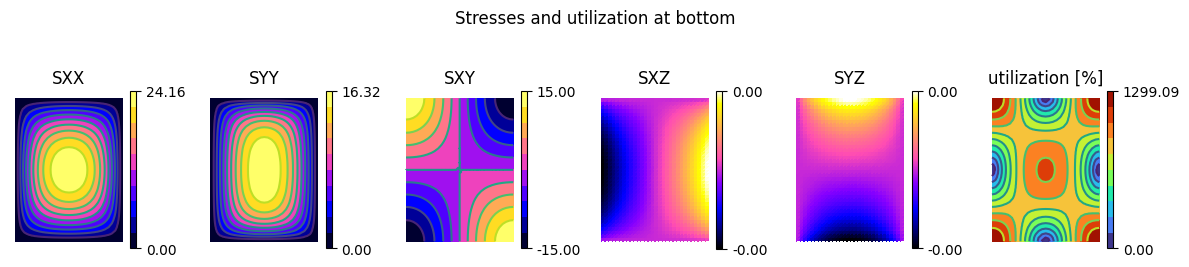

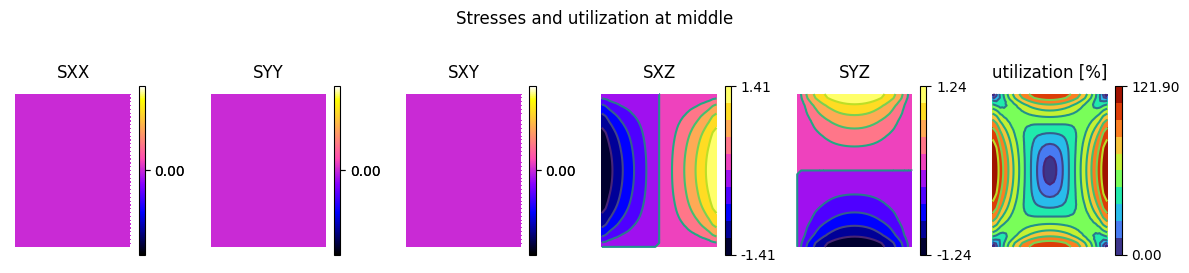

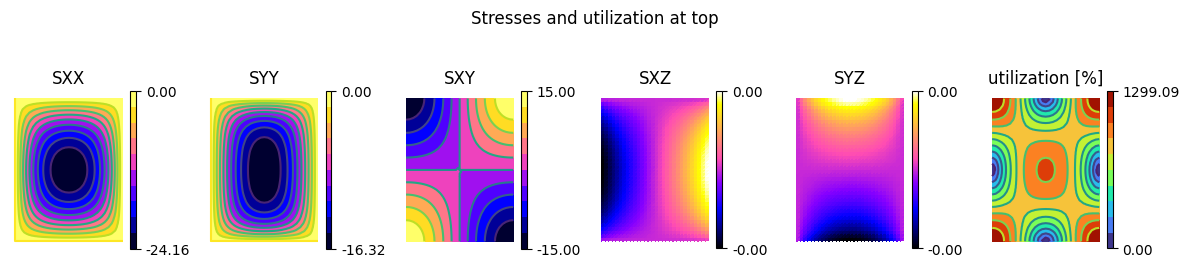

In [6]:
import numpy as np

load_case_results = results["LG1", "LC1"]
strains = load_case_results[:, 3:8]
shear_forces = load_case_results[:, 11:13]
z = np.array([-1.0, 0.0, 1.0])

stresses = section.calculate_stresses(strains=strains, shear_forces=shear_forces, z=z).values
util = section.utilization(strains=strains, shear_forces=shear_forces, z=z).values

plot_2d_stresses(stresses[:, 0], util[:, 0], z="bottom")
plot_2d_stresses(stresses[:, 1], util[:, 1], z="middle")
plot_2d_stresses(stresses[:, 2], util[:, 2], z="top")

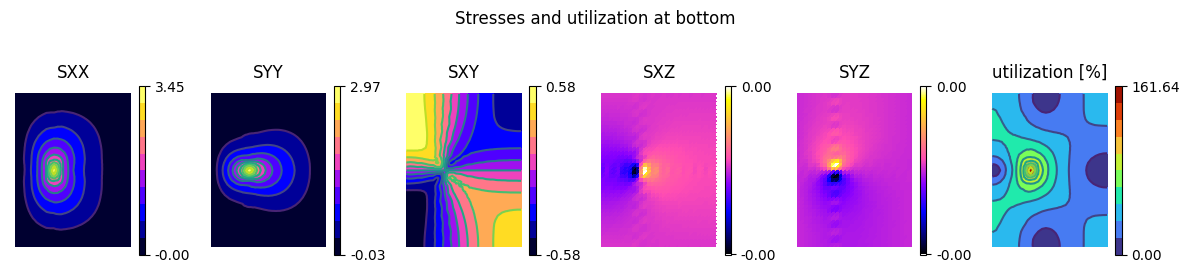

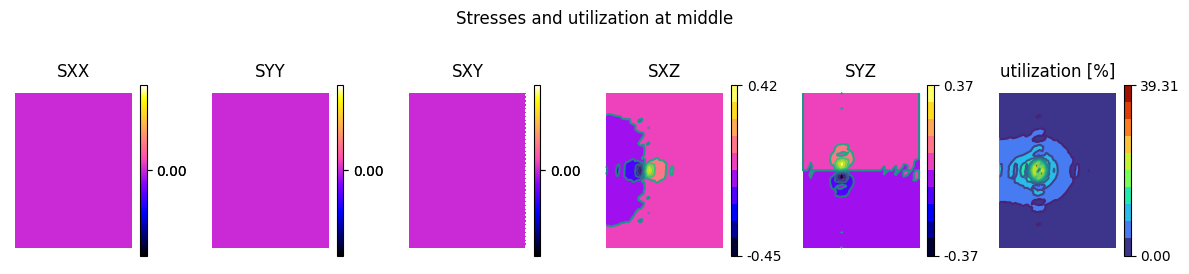

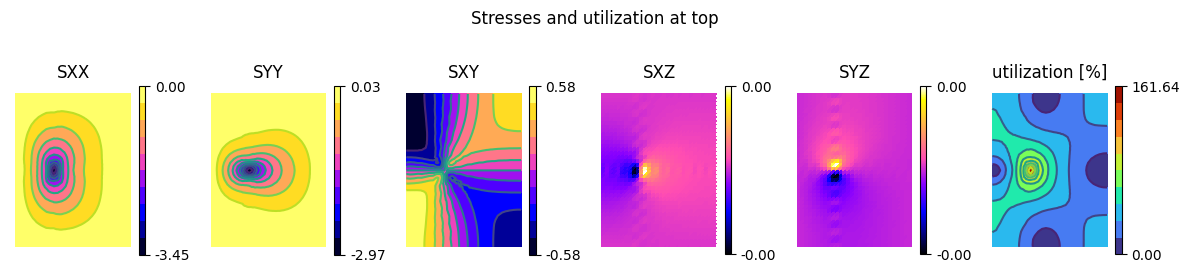

In [7]:
load_case_results = results["LG2", "LC3"]
strains = load_case_results[:, 3:8]
shear_forces = load_case_results[:, 11:13]
z = np.array([-1.0, 0.0, 1.0])

stresses = section.calculate_stresses(strains=strains, shear_forces=shear_forces, z=z).values
util = section.utilization(strains=strains, shear_forces=shear_forces, z=z).values

plot_2d_stresses(stresses[:, 0], util[:, 0], z="bottom")
plot_2d_stresses(stresses[:, 1], util[:, 1], z="middle")
plot_2d_stresses(stresses[:, 2], util[:, 2], z="top")

## Parallel plot

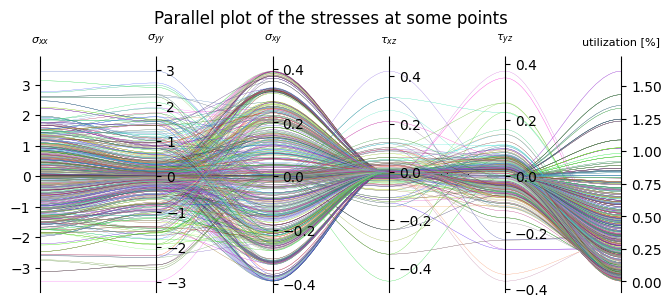

In [8]:
from sigmaepsilon.mesh.plotting import parallel_mpl
import numpy as np

load_case_results = results["LG2", "LC3"]
strains = load_case_results[300:600, 3:8]
shear_forces = load_case_results[300:600, 11:13]
z = np.array([-1.0, 0.0, 1.0])

stresses = section.calculate_stresses(strains=strains, shear_forces=shear_forces, z=z).values
util = section.utilization(strains=strains, shear_forces=shear_forces, z=z).values

nXY, nZ, nStress = stresses.shape
stresses = stresses.reshape((nXY*nZ, nStress))
util = util.reshape((nXY*nZ))

colors = np.random.rand(stresses.shape[0], 3)
labels = [str(i) for i in range(stresses.shape[-1])]
values = [stresses[:, i] for i in range(stresses.shape[-1])]
values += [util, ]

labels = [r"$\sigma_{xx}$", r"$\sigma_{yy}$", r"$\sigma_{xy}$", r"$\tau_{xz}$", r"$\tau_{yz}$"]
labels += [r"utilization [%]"]

_ = parallel_mpl(
    values,
    labels=labels,
    padding=0.05,
    lw=0.2,
    colors=colors,
    title="Parallel plot of the stresses at some points",
)

## Plotting through the thickness

Sometimes we do want to see how the stresses change through the thickness, at a specific point.

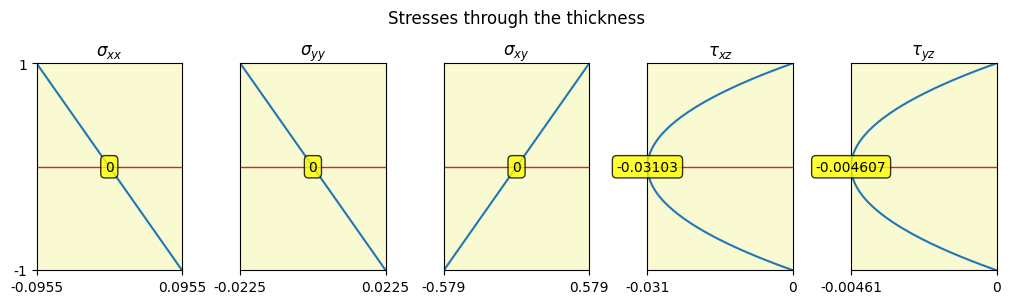

In [9]:
from sigmaepsilon.mesh.plotting.mpl.parallel import aligned_parallel_mpl
import numpy as np

load_case_results = results["LG2", "LC3"]
strains = load_case_results[:, 3:8]
shear_forces = load_case_results[:, 11:13]

n_data = 150
z = np.linspace(-1.0, 1.0, n_data)
stresses = section.calculate_stresses(strains=strains, shear_forces=shear_forces, z=z).values

labels = [r"$\sigma_{xx}$", r"$\sigma_{yy}$", r"$\sigma_{xy}$", r"$\tau_{xz}$", r"$\tau_{yz}$"]

fig = aligned_parallel_mpl(
    stresses[50, :, :],
    z,
    yticks=[-1, 1],
    y0=0.0,
    figsize=(12, 3),
    suptitle="Stresses through the thickness",
    labels=labels,
)

# Adjusts the top of the subplots to make room for the title
fig.subplots_adjust(top=0.80) 

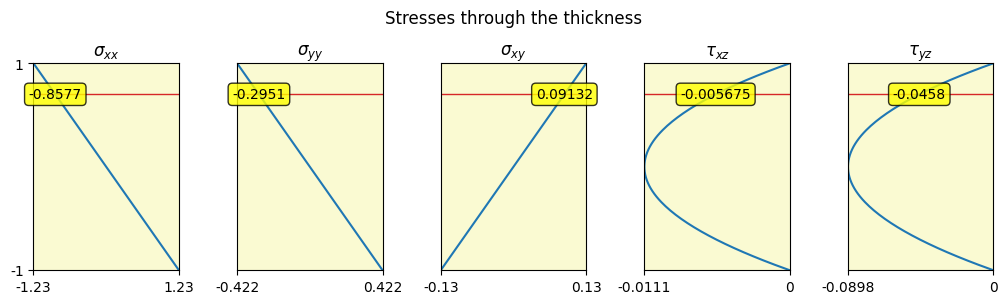

In [10]:
coords = np.array([[Lx / 3, Ly / 3, 0.0]])
results = plate.solve(loads, coords)

load_case_results = results["LG2", "LC3"]
strains = load_case_results[:, 3:8]
shear_forces = load_case_results[:, 11:13]
stresses = section.calculate_stresses(strains=strains, shear_forces=shear_forces, z=z).values

fig = aligned_parallel_mpl(
    stresses,
    z,
    yticks=[-1, 1],
    y0=0.7,
    suptitle="Stresses through the thickness",
    figsize=(12, 3),
    labels=labels,
)

# Adjusts the top of the subplots to make room for the title
fig.subplots_adjust(top=0.80)  